# Gaussian Process using Tanimoto and MinMax Tanimoto kernel

In [1]:
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from rdkit import Chem
from pandas import Series, DataFrame
from sklearn.metrics import r2_score
from sklearn import cross_validation
from GPz.model import GPR
from GPz.kern import Tanimoto, MinMaxTanimoto, Pharmacore
from scipy.stats import norm
from IPython.core.pylabtools import figsize
from IPython.core.display import display

SAVE_FIG = True

if SAVE_FIG:
    from matplotlib import rcParams  
    rcParams['axes.labelsize'] = 9  
    rcParams['xtick.labelsize'] = 9  
    rcParams['ytick.labelsize'] = 9  
    rcParams['legend.fontsize'] = 9 
    default_fig_w = 8
    default_fig_h = 5
else:
    default_fig_w = 16
    default_fig_h = 10

%matplotlib inline
figsize(default_fig_w, default_fig_h)

# Load and adjust data

In [2]:
df_std1 = pd.read_csv('../data/std1_mh_11_pubchem_hmdb.csv', keep_default_na=False)
df_std2 = pd.read_csv('../data/std2_mh_11_pubchem_hmdb.csv', keep_default_na=False)

# Removed heavy molecules
df_std1 = df_std1[df_std1['EXACT_MASS'] <= 280]
df_std2 = df_std2[df_std2['EXACT_MASS'] <= 280]

df_std1.drop(0, axis=0, inplace=True)
df_std1['JCHEM_ACIDIC_PKA'] = df_std1['JCHEM_ACIDIC_PKA'].astype(float)

df_merged = pd.concat([df_std1, df_std2])
df_merged.reset_index(inplace=True)

max_intensity = df_merged['Dil_1_1'].max()
df_merged['RRF'] = df_merged['Dil_1_1'] / max_intensity
df_merged['RRF_org'] = df_merged['RRF']
df_merged['RRF'] = np.log(df_merged['RRF'])
df_merged['mol'] = df_merged['InChI'].apply(lambda x: Chem.MolFromInchi(x))

In [3]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_merged, df_merged[['RRF']], test_size=0.25, random_state=3)

In [4]:
def execute_gp(X_train, y_train, X_test, n_var, alpha, kern_type):
    if kern_type == 'MinMaxTanimoto':
        kern = MinMaxTanimoto
    elif kern_type == 'Tanimoto':
        kern = Tanimoto
    else:
        raise ValueError('kern_type')
    
    kernel = kern(X_train, X_test, label='mol', alpha=alpha, temp_dir='../data/')
    gpr = GPR(X_train, y_train, kernel=kernel)
    gpr.noise_variance = n_var
    
    mu, var = gpr.predict(X_test)
    s = np.sqrt(var)
    
    return mu, s

def plot_results(y_test, mu, s, title):
    plt.xlabel('Measured (log)')
    plt.ylabel('Predicted (log)')
    plt.scatter(y_test, mu)
    
    ylim = plt.ylim()
    plt.errorbar(y_test, mu, yerr=s, fmt='o', elinewidth=1, capthick=1, capsize=3, lolims=False, uplims=False)
    # plt.ylim(*ylim)
    
    xlim = plt.xlim()
    plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
    plt.xlim(*xlim)
    
    plt.grid(True)
    plt.title(title)

In [5]:
def cv(arr_nvar, kern_type, name):
    k_fold = cross_validation.KFold(len(X_train), n_folds=5)

    grid_results = []
    alphas = np.linspace(0.001, 1, num=10)

    for i, (train_fold, test_fold) in enumerate(k_fold):
        X_train_fold = X_train.iloc[train_fold]
        y_train_fold = X_train.iloc[train_fold]['RRF']
        X_test_fold = X_train.iloc[test_fold]
        y_test_fold = X_train.iloc[test_fold]['RRF']

        for p_nvar, p_a in itertools.product(arr_nvar, alphas):
            mu, s = execute_gp(X_train_fold, y_train_fold, X_test_fold, p_nvar, p_a, kern_type)
            log_likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(y_test_fold, mu, s)])
            grid_results.append((p_nvar, p_a, log_likelihood))
    
    # Find the best parameter
    df = DataFrame(grid_results, columns=['Param', 'Alpha', 'LogLikelihood'])
    best = df.groupby(['Param', 'Alpha']).agg({'LogLikelihood' : np.mean}).sort(['LogLikelihood'], ascending=False)
    display(best.head(5))
    
    # Fit and plot
    n_var = best.iloc[0].name[0]
    alpha = best.iloc[0].name[1]
    print(n_var, alpha)

    mu, s = execute_gp(X_train, X_train['RRF'], X_test, n_var, alpha, kern_type)
    train_mu, train_s = execute_gp(X_train, X_train['RRF'], X_train, n_var, alpha, kern_type)

    figsize(1.45 * default_fig_w, default_fig_h)

    ax = plt.subplot(1, 2, 1)
    r2 = r2_score(X_test['RRF'], mu)
    likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(X_test['RRF'], mu, s)])
    print('Test Log-likelihood', likelihood)
    plot_results(X_test['RRF'], mu, s, title='Test $R^2$ = {:.3f}'.format(r2))
    for x, y, label in zip(X_test['RRF'], mu, X_test['Name']):
        ann = ax.annotate(label, (x + 0.002, y), alpha=0.8)
        
    plt.subplot(1, 2, 2)
    r2 = r2_score(X_train['RRF'], train_mu)
    likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(X_train['RRF'], train_mu, train_s)])
    print('Training Log-likelihood', likelihood)
    plot_results(X_train['RRF'], train_mu, train_s, title='Training $R^2$ = {:.3f}'.format(r2))

    plt.tight_layout(pad=0.1)

    if SAVE_FIG:
        plt.savefig('../figures/' + name + '.pdf')

    plt.show()
    return n_var, alpha

In [6]:
def correction(mu, s, name):
    NUM_SAMPLES = 1000

    def draw_adjusted_samples(row):
        """
        Draw sample from the predicted distribution
        and adjust it by substracting the true value
        """
        return list(np.exp(np.random.normal(row['mu'], row['scale'], NUM_SAMPLES)))

    df_results = DataFrame(
        {
            'Name': X_test['Name'],
            'mu': mu.ravel(),
            'scale': s.ravel(), 
            'logRRF': y_test['RRF'],
            'RRF': X_test['RRF_org']
        },
        columns=['Name', 'RRF' ,'logRRF', 'mu', 'scale'])
    df_results['samples'] = df_results.apply(draw_adjusted_samples, axis=1)

    # df_results.head(10)
    df_results['Corrected'] = df_results.apply(lambda x: list(x['RRF'] / np.array(x['samples'])), axis=1)
    df_results['Corrected_Median'] = df_results['Corrected'].apply(lambda c: np.median(c))
    # df_results.head(3)
    df_results['Corrected_diff'] = df_results['Corrected_Median'].apply(lambda x: np.abs(np.log10(x)))
    df_results['Measured_diff'] = df_results['RRF'].apply(lambda x: np.abs(np.log10(x)))
    df_results['IsItBetter'] = df_results.apply(lambda x: x['Corrected_diff'] < x['Measured_diff'], axis=1)
    print('True', len(df_results[df_results['IsItBetter'] == True]))
    print('False', len(df_results[df_results['IsItBetter'] == False]))
    #---
    is_better = df_results['IsItBetter'].reset_index(drop=True)
    df_bc = df_results
    df_bc[['Name', 'Corrected_Median']].to_csv('../data/' + name + '.csv', index=False)
    figsize(1.4 * default_fig_w, 1.2 * default_fig_h)
    plt.figure()
    plt.scatter(np.arange(1, len(df_bc['RRF']) + 1), df_bc['RRF'], color=sns.xkcd_rgb["blue"], marker='o', s=70, alpha=0.5)

    boxprops = dict(linestyle='-', linewidth=1, color=sns.xkcd_rgb["denim blue"])

    medianprops = dict(linestyle='-', linewidth=1, color=sns.xkcd_rgb["pale red"])

    meanlineprops = dict(linestyle='-', linewidth=1, color=sns.xkcd_rgb["denim blue"])

    whiskerprops = dict(linestyle='--', linewidth=1)

    capprops = dict(linestyle='-', linewidth=1)

    plt.boxplot(list(df_bc['Corrected']), labels=df_bc['Name'].values, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
    plt.yscale('log')

    plt.bar(is_better[is_better == True].index + 1, [1e16] * len(is_better[is_better == True]), color='green', alpha=0.07, align='center')
    plt.bar(is_better[is_better == False].index + 1, [1e16] * len(is_better[is_better == False]), color='red', alpha=0.07, align='center')

    plt.axhline(1, color=sns.xkcd_rgb["medium green"], linewidth=1)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.ylim([1e-10, 1e6])

    plt.tight_layout(pad=0.1)

    if SAVE_FIG:
        plt.savefig('../figures/' + name + '.pdf')

    plt.show()

# MinMax Tanimoto

,,LogLikelihood
Param,Alpha,
2.777778,0.112,-26.830724
2.888889,0.112,-26.832086
2.666667,0.112,-26.834558
3.000000,0.112,-26.837991
2.555556,0.112,-26.844351


2.77777777778 0.112
Test Log-likelihood -51.700265161
Training Log-likelihood -108.616453773


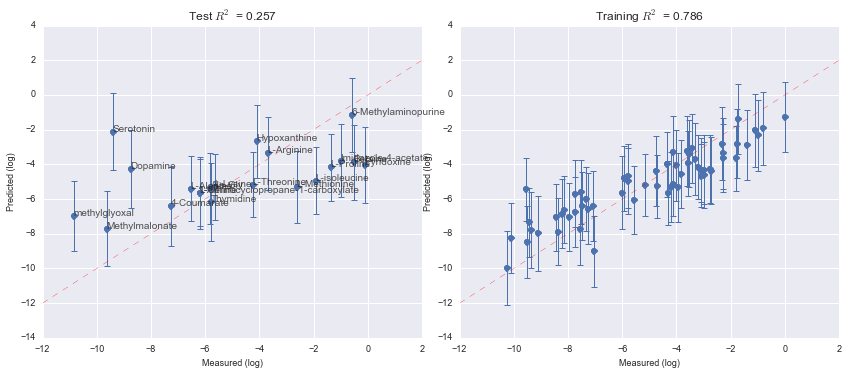

True 15
False 6


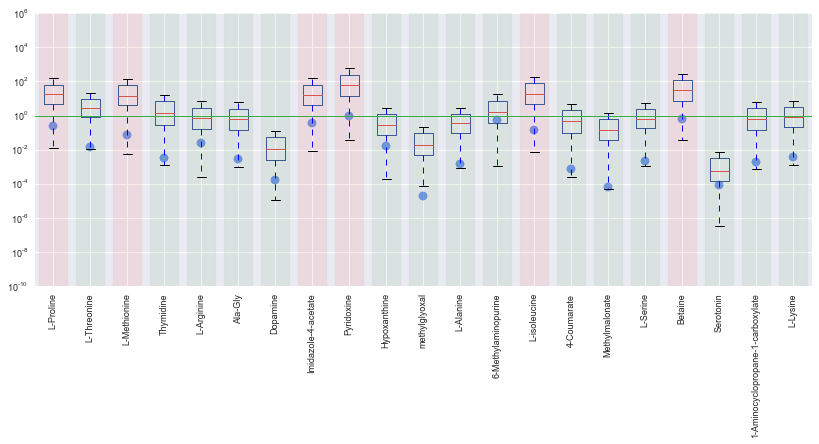

In [7]:
arr_nvar = np.linspace(2, 3, num=10)
n_var, alpha = cv(arr_nvar, 'MinMaxTanimoto', 'gp_gu_minmax')

mu, s = execute_gp(X_train, X_train['RRF'], X_test, n_var, alpha, 'MinMaxTanimoto')
correction(mu, s, 'minmax_gu_correction')

# Tanimoto

LogLikelihood
Param    Alpha               
1.888889 1.000     -26.787668
2.333333 0.889     -26.794178
         1.000     -26.795335
1.888889 0.889     -26.808991
2.333333 0.778     -26.809092

1.88888888889 1.0
Test Log-likelihood -55.6909759956
Training Log-likelihood -99.9446994322


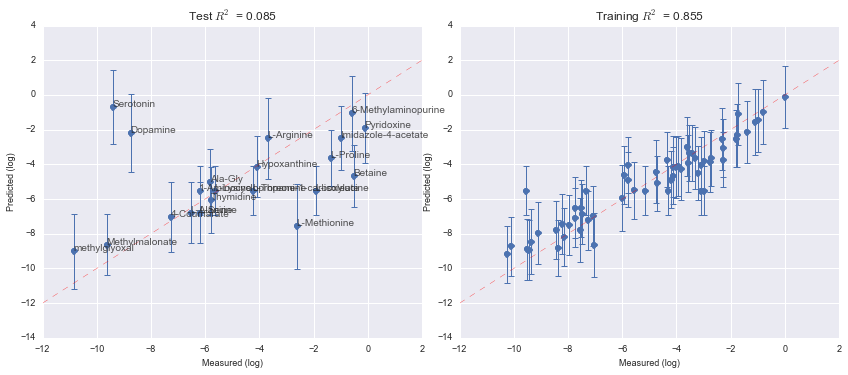

In [8]:
arr_nvar = np.linspace(1, 5, num=10)
n_var, alpha = cv(arr_nvar, 'Tanimoto', 'gp_gu_tanimoto')

True 15
False 6


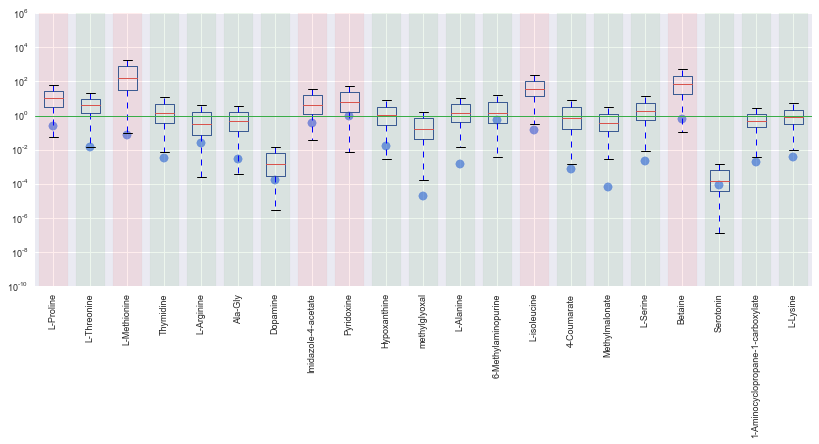

In [9]:
mu, s = execute_gp(X_train, X_train['RRF'], X_test, n_var, alpha, kern_type='Tanimoto')
correction(mu, s, 'tanimoto_gu_correction')